In [31]:
import pandas as pd

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

The effect of diversification

In this exercise you're going to compare performance of four individual stocks, to a portfolio of the same four stocks. You'll see that 2 out of the four stocks will under-perform over a time period of roughly four years, and two will perform quite well.

The stocks you're going to investigate are General Electric, JP Morgan, Microsoft and Proctor & Gamble.

Let's play a little game: pick one stock to invest in, then, let's see how it would have performed over time. There's a 50-50 chance that you'll pick a winning stock, versus a losing stock. Let's look at the data and see whether your stock is one of strong performers.

Available is a data set called stock_returns containing the cumulative returns of these four stocks over time, plus a portfolio of these stocks.

In [23]:
small_portfolio = pd.read_csv('small_portfolio.csv', index_col=0)
small_portfolio

,GE,JPM,MSFT,PG
date,,,,
2015-01-02,25.06,62.49,46.760,90.44
2015-01-05,24.60,60.55,46.325,90.01
2015-01-06,24.07,58.98,45.650,89.60
2015-01-07,24.08,59.07,46.230,90.07
2015-01-08,24.37,60.39,47.590,91.10
...,...,...,...,...
2018-03-21,13.88,114.74,92.480,77.04
2018-03-22,13.35,109.95,89.790,76.41
2018-03-23,13.07,107.01,87.180,75.91


In [24]:
stock_returns = small_portfolio/small_portfolio.iloc[0]
stock_returns['portfolio'] = stock_returns.mean(axis=1) 
# all the weights of the stocks in the portfolio are equal, hence we are looking at an equal weighted portfolio.
stock_returns

,GE,JPM,MSFT,PG,portfolio
date,,,,,
2015-01-02,1.000000,1.000000,1.000000,1.000000,1.000000
2015-01-05,0.981644,0.968955,0.990697,0.995245,0.984135
2015-01-06,0.960495,0.943831,0.976262,0.990712,0.967825
2015-01-07,0.960894,0.945271,0.988666,0.995909,0.972685
2015-01-08,0.972466,0.966395,1.017750,1.007298,0.990977
...,...,...,...,...,...
2018-03-21,0.553871,1.836134,1.977759,0.851835,1.304900
2018-03-22,0.532721,1.759482,1.920231,0.844870,1.264326
2018-03-23,0.521548,1.712434,1.864414,0.839341,1.234434


In [25]:
def plot_pct_returns(df):
    fig, ax = plt.subplots()
    ax.plot(df.index, df.MSFT, marker='', color='green', linewidth=2, label="MSFT")
    ax.plot(df.index, df.portfolio, linewidth=2, linestyle='dashed', color='skyblue', label='portfolio')
    ax.plot(df.index, df.PG, marker='', color='pink', linewidth=2, label="PG")
    ax.plot(df.index, df.JPM, color='yellow', linewidth=2, label='JPM')
    ax.plot(df.index, df.GE, color='red', linewidth=2, label='GE')
    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    #ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator((1,4,7,10)))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("\n%Y"))
    #ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter("%b"))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    plt.legend()
    plt.show()

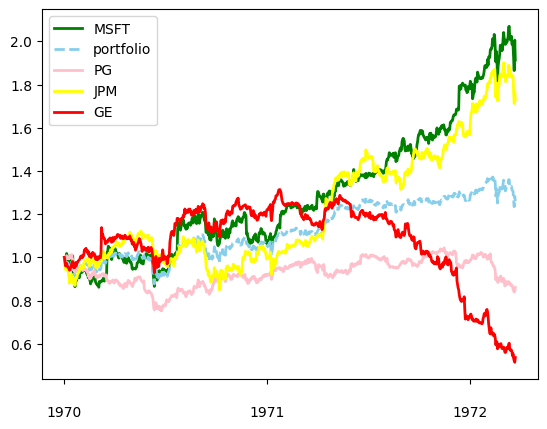

In [26]:
plot_pct_returns(stock_returns)

Calculate mean returns

In this exercise, you're going to calculate performance for a four stock portfolio over the period January 2015 through March 2019. The portfolio consists of Proctor & Gamble, Microsoft, JP Morgan and General Electric stocks. You'll discover that multiplying the mean return of each stock with its portfolio weight, is a very quick and straightforward way to calculate portfolio performance over a given period of time.

In [28]:
# Calculate percentage returns
returns = small_portfolio.pct_change()
returns

,GE,JPM,MSFT,PG
date,,,,
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,-0.018356,-0.031045,-0.009303,-0.004755
2015-01-06,-0.021545,-0.025929,-0.014571,-0.004555
2015-01-07,0.000415,0.001526,0.012705,0.005246
2015-01-08,0.012043,0.022346,0.029418,0.011436
...,...,...,...,...
2018-03-21,0.017595,0.000872,-0.006979,-0.016218
2018-03-22,-0.038184,-0.041747,-0.029087,-0.008178
2018-03-23,-0.020974,-0.026739,-0.029068,-0.006544


In [29]:
# Calculate individual mean returns 
meanDailyReturns = returns.mean()
meanDailyReturns

GE     -0.000675
JPM     0.000769
MSFT    0.000907
PG     -0.000144
dtype: float64

In [32]:
# Define weights for the portfolio
weights = np.array([0.5, 0.2, 0.2, 0.1])

# Calculate expected portfolio performance
portReturn = np.sum(meanDailyReturns*weights)

portReturn

-1.6782226618545438e-05

Portfolio cumulative returns

In the previous exercise, you've calculated the mean performance over a period of time. This gives you one performance number for that entire period. But what if you would want to plot the development of the performance over time? For that, you will need the cumulative performance, not the mean performance. Just like with interest in your bank account, the cumulative performance gives you the compounded return at each date in your dataset. It tells you; "up until today, this is what the total return has been since the start of my data."

Remember because of the compounding effect, you need to use cumprod() for this calculation.

In [33]:
# Create portfolio returns column
returns['Portfolio']= returns.dot(weights)
# The 'Portfolio' column represents the total return of the portfolio for each corresponding time period, 
# taking into account the weights of the individual assets.
returns

,GE,JPM,MSFT,PG,Portfolio
date,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.018356,-0.031045,-0.009303,-0.004755,-0.017723
2015-01-06,-0.021545,-0.025929,-0.014571,-0.004555,-0.019328
2015-01-07,0.000415,0.001526,0.012705,0.005246,0.003579
2015-01-08,0.012043,0.022346,0.029418,0.011436,0.017518
...,...,...,...,...,...
2018-03-21,0.017595,0.000872,-0.006979,-0.016218,0.005954
2018-03-22,-0.038184,-0.041747,-0.029087,-0.008178,-0.034077
2018-03-23,-0.020974,-0.026739,-0.029068,-0.006544,-0.022303


In [36]:
# Calculate cumulative returns, to determine the cumulative return over time, accounting for the compounding effect of returns

daily_cum_ret=(1 + returns).cumprod()
# Adding 1 to each return value effectively converts the daily return percentages into factors. 
# For example, a daily return of 5% (0.05) becomes 1.05, representing a 5% increase.
# The cumprod() function computes the cumulative product of the elements along the specified axis (default is axis=0, i.e., row-wise). 
# This means it multiplies the current value by all previous values in the series.

daily_cum_ret

,GE,JPM,MSFT,PG,Portfolio
date,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN
2015-01-05,0.981644,0.968955,0.990697,0.995245,0.982277
2015-01-06,0.960495,0.943831,0.976262,0.990712,0.963292
2015-01-07,0.960894,0.945271,0.988666,0.995909,0.966739
2015-01-08,0.972466,0.966395,1.017750,1.007298,0.983674
...,...,...,...,...,...
2018-03-21,0.553871,1.836134,1.977759,0.851835,0.974287
2018-03-22,0.532721,1.759482,1.920231,0.844870,0.941086
2018-03-23,0.521548,1.712434,1.864414,0.839341,0.920097


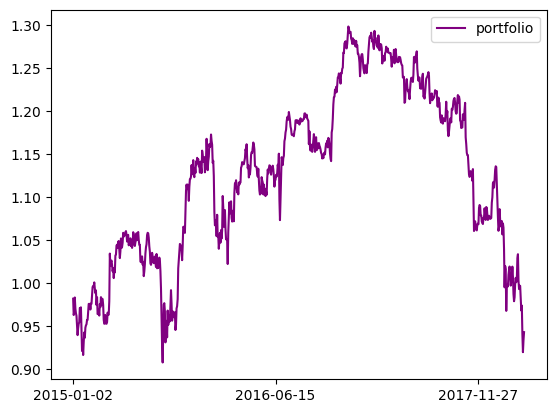

In [37]:
# Plot the portfolio cumulative returns only
fig, ax = plt.subplots()
ax.plot(daily_cum_ret.index, daily_cum_ret.Portfolio, color='purple', label="portfolio")
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
plt.legend()
plt.show()

Portfolio variance

It's time to calculate the risk of our 4-stock portfolio. Let's start with the pricing data, available under data. You'll have to calculate daily percentage returns and assign weights to your portfolio. You'll then continue by calculating the covariance matrix, and use the following formula: Portfolio variance = Weights transposed x (Covariance matrix x Weights) to get the final portfolio variance.

As calculating portfolio variance is an important part of portfolio analysis

In [40]:
returns.drop('Portfolio', axis=1, inplace=True)
returns

,GE,JPM,MSFT,PG
date,,,,
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,-0.018356,-0.031045,-0.009303,-0.004755
2015-01-06,-0.021545,-0.025929,-0.014571,-0.004555
2015-01-07,0.000415,0.001526,0.012705,0.005246
2015-01-08,0.012043,0.022346,0.029418,0.011436
...,...,...,...,...
2018-03-21,0.017595,0.000872,-0.006979,-0.016218
2018-03-22,-0.038184,-0.041747,-0.029087,-0.008178
2018-03-23,-0.020974,-0.026739,-0.029068,-0.006544


In [41]:
# Assign portfolio weights
weights = np.array([0.05, 0.4, 0.3, 0.25])

# Calculate the covariance matrix 
cov_matrix = (returns.cov())*250

cov_matrix

,GE,JPM,MSFT,PG
GE,0.045987,0.022828,0.016285,0.010101
JPM,0.022828,0.046660,0.024135,0.010812
MSFT,0.016285,0.024135,0.054054,0.014144
PG,0.010101,0.010812,0.014144,0.020645


In [42]:
# Calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))

# Print the result
print(str(np.round(port_variance, 4) * 100) + '%')

2.55%


Standard deviation versus variance

the standard deviation  is simply the square root of the variance. Both measures are used in practice to calculate market or stock volatility. Why should you use one or the other?

In the variance calculation we square the weights and the variances. Because of this squaring, the variance is no longer in the same unit of measurement as the original data. Taking the root of the variance means the standard deviation is restored to the original unit of measure and therefore much easier to interpret.

In [43]:
# Calculate the standard deviation by taking the square root
port_standard_dev = np.sqrt(port_variance)

# Print the results 
print(str(np.round(port_standard_dev, 4) * 100) + '%')

# The standard deviation tells you how much the portfolio's return can deviate from the mean historical return. 
# If a portfolio has a 12% average rate of return and a standard deviation of 4%, its return will range from 8-16%. 
# The mean historic return of this particular portfolio is actually close to zero. 
# With an average standard deviation of roughly 16%, this means you're getting a bad deal here! 

15.959999999999999%
